In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
from matplotlib import gridspec
import h5py
import math
import numpy as np
import matplotlib.ticker as plticker
import sys
import os
import qutip as q
from pylab import *
import gc
import pprint

folder = os.getcwd()
sys.path.insert(0,os.path.join(folder,'functions'))
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rcParams['figure.figsize'] = (6.0, 4.0)  
mpl.rcParams['font.size'] = 14  
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.subplot.bottom'] = .1  

In [4]:
#outputs the wigner function of a given state
xvec = np.linspace(-7, 7, 100)
def plot_wig(rho, fig, xvec=xvec):
    plt.figure(fig);
    plt.clf()
    gs = gridspec.GridSpec(2, 2, width_ratios=[1., .25], height_ratios=[.25, 1.])
    gs.update(right=.98)
    ax = plt.subplot(gs[2])
    axv = plt.subplot(gs[3], sharey=ax)
    axh = plt.subplot(gs[0], sharex=ax)
    plt.subplots_adjust(hspace=.02, wspace=.02)
    plt.setp(axh.get_xticklabels(), visible=False)
    plt.setp(axv.get_yticklabels(), visible=False)
    Wig = q.wigner(rho, xvec, xvec, g=2)
    Wig = Wig / (np.sum(Wig) * (-xvec[0] + xvec[1]))
    scale = np.max(np.abs(Wig));
    ax.contourf(xvec, xvec, Wig, levels=np.linspace(-scale, scale, 501),cmap='RdBu_r',vmax=1 * scale, vmin=-1 * scale)
    ax.grid(False)
    axh.grid(False)
    axv.grid(False)
    axh.plot(xvec, np.sum(Wig, axis=0), 'r', zorder=+10, label='Sim.')
    axv.plot(np.sum(Wig, axis=1), xvec, 'r', zorder=+10)
    axh.set_xlim(xvec.min(), xvec.max())
    axv.set_ylim(xvec.min(), xvec.max())
    ax.set_aspect('equal')
    ax.set_xlabel(r'$X$');
    ax.set_ylabel(r'$P$')
    axh.set_ylabel(r'$|\psi(X)|^2$');
    axv.set_xlabel(r'$|\psi(P)|^2$')
    
#define the state
def state(t,p):
    s=tensor(np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r)
    return s

The trace distance between the Unitary time propagator and its expansion to the first order is: (0.9976720148485556+0j)


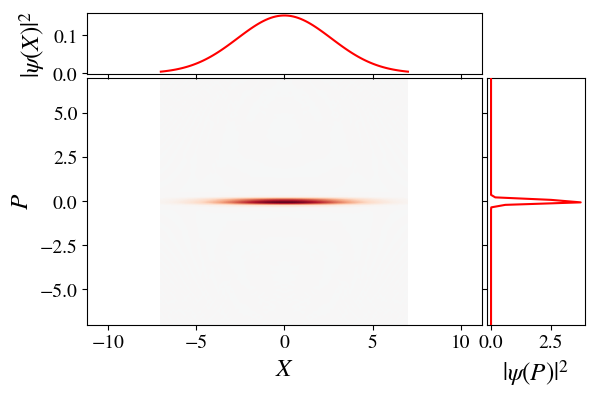

Im part of the weak value: (-0.9728724795109471+0j) (-0.035882885033707665+0j)
Re part of the weak value: 1.0180658399638887e-16j 1.0180658399638887e-16j


In [138]:
#dimension of the Hilbert space
N=270

#basis vectors
l = basis(2,1)
r = basis(2,0)

#here i select the initial and the final angles on the bloch sphere
ti=np.pi/2
pin=np.pi/(2)
tf=np.pi/2
pif=0

#pre-selected state
pre=state(ti,pin)

#post-selected state
post=state(tf,pif)

#create the possibility of a sqeezed quantum pointer
#sqeezed state
sqzparam=-1.65 #squeezing parameter choosen to be real and expressed in dB 
sq_op =q.squeeze(N, sqzparam)
sq_state=q.squeeze(N, sqzparam)*coherent(N, 0)

#add the quantum pointer
#squeezed pointer
rho0=(tensor(pre,sq_state)*tensor(pre,sq_state).dag()).unit()
#coherent pointer
rho1=(tensor(pre,coherent(N, 0))*tensor(pre,coherent(N, 0)).dag()).unit()

#spin dependent hamiltonian
coupl=1
sdf_t1=1
ll=tensor(l,l)
llt=ll*ll.dag()
rr=tensor(r,r)
rrt=rr*rr.dag()
idd=qeye(2)
spindep=tensor(idd,llt-rrt,momentum(N))
dist=0
#weak measurement protocol
a=((tensor(idd,idd,idd,qeye(N))-1.j*coupl*sdf_t1*spindep)*rho0*((tensor(idd,idd,idd,qeye(N))-1.j*coupl*sdf_t1*spindep).dag())).unit()
a1=((-1.j*coupl*sdf_t1*spindep).expm()*rho0*(-1.j*coupl*sdf_t1*spindep).expm().dag()).unit()
dist=(a.dag()*a1).tr()
#show the trace distance (hilbert-schmidt inner product) of the approximated time propagator and the full time propagator
print("The trace distance between the Unitary time propagator and its expansion to the first order is:",(a.dag()*a1).tr())

#final projection and wigner function of the pointer
d=post*post.dag()
dd=tensor(d,qeye(N))
b=(((dd.dag()*a1)).ptrace(3)).unit()
plot_wig(b, fig='test')
plt.show()



#variance of the momentum at the initial time
b0=(sq_state*sq_state.dag()).unit()
k1=(b0*momentum(N)).tr()
k2=(b0*momentum(N)*momentum(N)).tr()
vark=k2-k1*k1
#prints the expectation value of the position and momentum operator + weak value of the observable we are measuring
k=(b*momentum(N)).tr()
print("The expectation value of the momentum operator is:",k)
print("Im part of the weak value:",k/(2*coupl*sdf_t1*vark))
p=(b*position(N)).tr()
print("The expectation value of the position operator is:",p)
print("Re part of the weak value:",p/(coupl*sdf_t1))
